# Objectives
- Convert a regression question into a classification question
- Modify the classification threshold and and determine how that modification influences the model
- Experiment with different classification metrics to determine the model's effectiveness

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print ("Imported modules")

2022-10-20 11:29:28.250636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-20 11:29:28.482912: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-20 11:29:28.550036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-20 11:29:28.550075: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

Imported modules


## Load dataset from the internet

In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

train_df = train_df.reindex(np.random.permutation(train_df.index))

## Normalize values using Z-scores of the values

In [3]:
#calculate Z-score and write to new pandas DataFrame
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean) / train_df_std

#examine some of the normalized values
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
1475,1.2,-0.6,-0.9,3.1,2.2,-0.0,-0.1,1.2,0.2
1723,1.2,-0.9,-1.5,-0.5,-0.5,-0.6,-0.7,-0.2,-0.4
13728,-1.2,0.8,0.6,-0.6,-0.7,-0.5,-0.7,1.0,0.3
6858,0.6,-0.8,0.6,0.4,0.8,1.0,0.9,-0.7,-0.8
8561,0.5,-0.7,0.6,0.3,-0.2,-0.2,-0.2,1.8,2.3


In [4]:
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean) / test_df_std

## Create a binary level

In [6]:
threshold = 265000
train_df_norm["median_house_value_is_high"] = (train_df["median_house_value"] > threshold).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df["median_house_value"] > threshold).astype(float)
train_df_norm["median_house_value_is_high"].head(8000)

1475    0.0
1723    0.0
13728   0.0
6858    0.0
8561    1.0
         ..
4301    0.0
118     0.0
9756    0.0
5056    0.0
12155   0.0
Name: median_house_value_is_high, Length: 8000, dtype: float64

## Represent features in feature column

In [7]:
feature_columns = []

median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

tr = tf.feature_column.numeric_column("total_rooms")
feature_columns.append(tr)

feature_layer = layers.DenseFeatures(feature_columns)

feature_layer(dict(train_df_norm))

2022-10-20 11:53:29.906681: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-20 11:53:29.906950: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-20 11:53:29.906966: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nsl54): /proc/driver/nvidia/version does not exist
2022-10-20 11:53:29.907497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[ 1.2261688 ,  3.1080275 ],
       [-0.19446942, -0.45490298],
       [ 0.999615  , -0.6457333 ],
       ...,
       [ 3.3096457 ,  0.15199248],
       [-0.39235675,  0.17905737],
       [ 3.2365909 , -0.48701385]], dtype=float32)>

## Build and Train model

In [13]:
def create_model(my_learning_rate, feature_layer, my_metrics):
    
    model = tf.keras.models.Sequential()
    
    model.add(feature_layer)
    
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                   activation=tf.sigmoid),)
    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                 loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=my_metrics)
    
    return model


def train_model(model, dataset, epochs, label_name,
               batcj_size=None, shuffle=True):
    
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                       epochs=epochs, shuffle=shuffle)
    
    epochs = history.epoch
    
    hist = pd.DataFrame(history.history)
    
    return epochs, hist

print("Defined create and train model functions")

Defined create and train model functions


## Plotting

In [14]:
def plot_curve(epochs, hist, list_of_metrics):
    
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    
    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)
        
    plt.legend()
    
print("Defined plot function")

Defined plot function


## Train and plot "ROC curve (Recursive Operating Characteristic Curve)"

Epoch 1/20
170/170 [==============================] - 0s 623us/step - loss: 0.6541 - accuracy: 0.2601
Epoch 2/20
170/170 [==============================] - 0s 584us/step - loss: 0.5790 - accuracy: 0.3174
Epoch 3/20
170/170 [==============================] - 0s 603us/step - loss: 0.5240 - accuracy: 0.5784
Epoch 4/20
170/170 [==============================] - 0s 599us/step - loss: 0.4833 - accuracy: 0.7044
Epoch 5/20
170/170 [==============================] - 0s 592us/step - loss: 0.4533 - accuracy: 0.7563
Epoch 6/20
170/170 [==============================] - 0s 580us/step - loss: 0.4318 - accuracy: 0.7814
Epoch 7/20
170/170 [==============================] - 0s 587us/step - loss: 0.4174 - accuracy: 0.7962
Epoch 8/20
170/170 [==============================] - 0s 574us/step - loss: 0.4084 - accuracy: 0.8030
Epoch 9/20
170/170 [==============================] - 0s 587us/step - loss: 0.4028 - accuracy: 0.8056
Epoch 10/20
170/170 [==============================] - 0s 590us/step - loss: 0.399

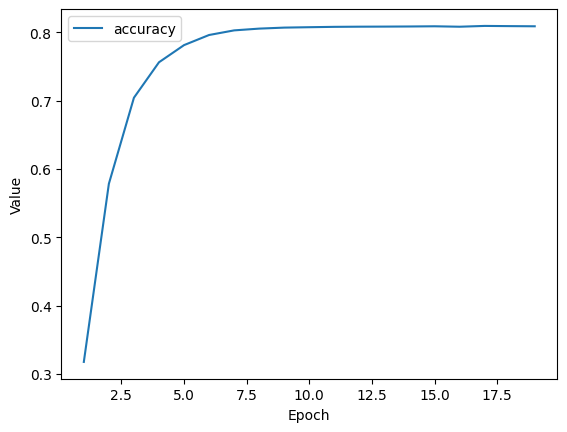

In [15]:
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

#establish the metrics the model will measure
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy',
                                   threshold=classification_threshold),]

my_model = create_model(learning_rate, feature_layer, METRICS)

epochs, hist = train_model(my_model, train_df_norm, epochs,
                          label_name, batch_size)

list_of_metrics_to_plot = ['accuracy']

plot_curve(epochs, hist, list_of_metrics_to_plot)

## Evaluate against test set

In [17]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))
                
my_model.evaluate(x = features, y = label, batch_size = batch_size)

30/30 [==============================] - 0s 651us/step - loss: 0.4069 - accuracy: 0.8013


[0.4068729281425476, 0.8013333082199097]

##### 80% accuracy is good but a model that always guesses "median_house_value_is_high is False" would be 75% accurate

## Adding precision and recall metrics

Epoch 1/20
170/170 [==============================] - 0s 648us/step - loss: 0.6983 - accuracy: 0.6556 - precision: 0.3002 - recall: 0.2844
Epoch 2/20
170/170 [==============================] - 0s 651us/step - loss: 0.6222 - accuracy: 0.7246 - precision: 0.4209 - recall: 0.2727
Epoch 3/20
170/170 [==============================] - 0s 656us/step - loss: 0.5604 - accuracy: 0.7687 - precision: 0.5725 - recall: 0.2929
Epoch 4/20
170/170 [==============================] - 0s 672us/step - loss: 0.5113 - accuracy: 0.7974 - precision: 0.7124 - recall: 0.3167
Epoch 5/20
170/170 [==============================] - 0s 664us/step - loss: 0.4739 - accuracy: 0.8131 - precision: 0.8004 - recall: 0.3353
Epoch 6/20
170/170 [==============================] - 0s 659us/step - loss: 0.4468 - accuracy: 0.8235 - precision: 0.8447 - recall: 0.3598
Epoch 7/20
170/170 [==============================] - 0s 678us/step - loss: 0.4282 - accuracy: 0.8291 - precision: 0.8638 - recall: 0.3749
Epoch 8/20
170/170 [=======

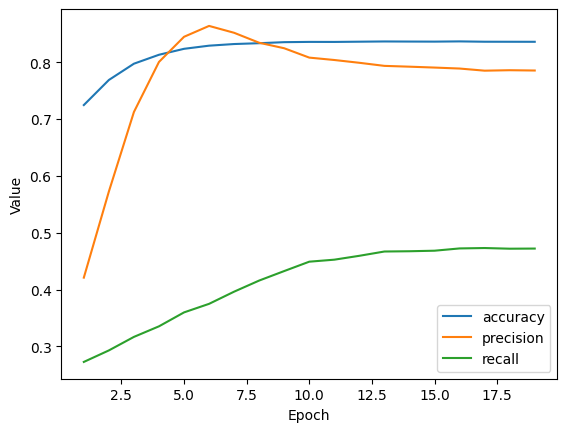

In [30]:
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.52

label_name = "median_house_value_is_high"

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy',
                                   threshold=classification_threshold),
    tf.keras.metrics.Precision(thresholds=classification_threshold,
                              name='precision'
                              ),
    tf.keras.metrics.Recall(thresholds=classification_threshold,
                            name='recall'),
    
]

my_model = create_model(learning_rate, feature_layer, METRICS)
epochs, hist = train_model(my_model, train_df_norm, epochs,
                          label_name, batch_size)

list_of_metrics_to_plot = ['accuracy', 'precision', 'recall']
plot_curve(epochs, hist, list_of_metrics_to_plot)

##### A classification_threshold of slightly over 0.5 appears to produce the highest accuracy (about 83%). Raising the classification_threshold  to 0.9 drops  accuracy by about 5%.  Lowering the classification_threshold  to 0.3 drops accuracy by  about 3%. 

## AUC (Area Under the ROC)

Epoch 1/20
170/170 [==============================] - 0s 619us/step - loss: 0.6155 - auc: 0.7897
Epoch 2/20
170/170 [==============================] - 0s 602us/step - loss: 0.5557 - auc: 0.8159
Epoch 3/20
170/170 [==============================] - 0s 624us/step - loss: 0.5083 - auc: 0.8274
Epoch 4/20
170/170 [==============================] - 0s 612us/step - loss: 0.4717 - auc: 0.8320
Epoch 5/20
170/170 [==============================] - 0s 629us/step - loss: 0.4446 - auc: 0.8349
Epoch 6/20
170/170 [==============================] - 0s 625us/step - loss: 0.4255 - auc: 0.8355
Epoch 7/20
170/170 [==============================] - 0s 630us/step - loss: 0.4129 - auc: 0.8364
Epoch 8/20
170/170 [==============================] - 0s 623us/step - loss: 0.4055 - auc: 0.8363
Epoch 9/20
170/170 [==============================] - 0s 654us/step - loss: 0.4012 - auc: 0.8367
Epoch 10/20
170/170 [==============================] - 0s 609us/step - loss: 0.3990 - auc: 0.8368
Epoch 11/20
170/170 [========

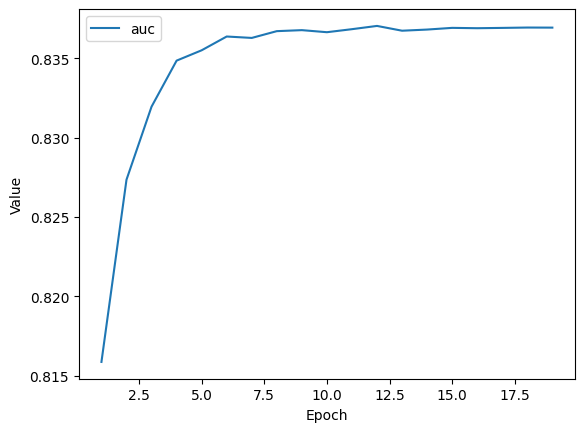

In [33]:
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"

#establish the metrics the model will measure
METRICS = [tf.keras.metrics.AUC(num_thresholds=100,name='auc'),]

my_model = create_model(learning_rate, feature_layer, METRICS)

epochs, hist = train_model(my_model, train_df_norm, epochs,
                          label_name, batch_size)

list_of_metrics_to_plot = ['auc']

plot_curve(epochs, hist, list_of_metrics_to_plot)